<center><img src="images/logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# Application of Deep Learning to Text and Image Data
## Module 3, Lab 4: Using Residual Layers

This notebook covers how to implement _residual layers_ and use them to make predictions. 

You will learn how to do the following:

- Define model evaluation metrics.
- Define training functions.
- Design residual layers.
- Compare the performance of residual layers.

You will use the Fashion-MNIST dataset to compare the performance of different residual layers. You will plot data over a variety of depths and examine how it compares after a single epoch of training or several epochs of training.

----

You will be presented with two kinds of exercises throughout the notebook: activities and challenges. <br/>

| <img style="float: center;" src="images/activity.png" alt="Activity" width="125"/>| <img style="float: center;" src="images/challenge.png" alt="Challenge" width="125"/>|
| --- | --- |
|<p style="text-align:center;">No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p> |<p style="text-align:center;">Challenges are where you can practice your coding skills.</p>

---
## Index

- [Load the Fashion-MNIST dataset](#Load-the-Fashion-MNIST-dataset)
- [Define the model evaluation metric and training functions](#Define-the-model-evaluation-metric-and-training-functions)
- [Design the residual layer](#Design-the-residual-layer)
- [Compare the performance of different residual layers](#Compare-the-performance-of-different-residual-layers)

---
## Load the Fashion-MNIST dataset

To get started, load the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) from `torchvision`. Then, define the training, validation, and test paths.

In [1]:
%%capture
# Install libraries
!pip install -q -U -r requirements.txt

To restart the kernel after installing the libraries, run the following cell.

In [2]:
from IPython.display import HTML, display
def restart_kernel_and_run_all_cells():
    display(HTML(
        '''
            <script>
                code_show = false;
                var cell_idx = Jupyter.notebook.get_cell_elements().index(cell_element);
                cell_idx++;
                function restart(){
                    IPython.notebook.kernel.restart();
                    IPython.notebook.execute_cells([cell_idx])
                }
                restart()
            </script>
        '''
    ))
#print("Before you continue, wait until the kernel is ready again.")
restart_kernel_and_run_all_cells()

In [3]:
print("You are ready to go to the next cell!")

You are ready to go to the next cell!


Import the PyTorch packages and modules. 

In [4]:
# Import plotting libraries
import matplotlib.pyplot as plt

# Import PyTorch
import torch
from torch import nn
from d2l import torch as d2l
import torchvision
from torch.utils import data
from torchvision import transforms
import torch.nn.functional as F

# Import helper libraries
import random
import numpy as np

# Import utility functions that provide answers to challenges
from MLUDTI_EN_M3_Lab4_quiz_questions import *

Check if the Amazon SageMaker instance has a GPU device available.

In [5]:
# If the output is 'cuda', it's on a GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
batch_size = 256

# Load the Fashion-MNIST data
train = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transforms.ToTensor(), download=True
)
test = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transforms.ToTensor() , download=True
)

train_iter = data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_iter = data.DataLoader(test, batch_size=batch_size, shuffle=False)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



---
## Define the model evaluation metric and training functions

Use the standard code to define the training function that returns the training loss.

Because you aren't concerned with model generalization, training loss shows the model's ability to fit a given distribution. Similar graphs for the test loss will show the same phenomenon. More importantly, you will see that this method doesn't learn highly predictive models, and it doesn't learn well-fit models.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">The following code cell defines a function to <i>compute the accuracy</i> for the model <b>net</b> on a dataset using a GPU. Review the code, identify how the accuracy is calculated, and then run the cell.</p>
    <br>
</div>

In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # Number of correct predictions, number of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">The following code cell defines the function that <i>trains</i> the model <b>net</b> using a GPU. Review the code, identify where it uses the accuracy evaluation function, and then run the cell.</p>
    <br>
</div>

In [8]:
def train(net, train_iter, test_iter, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters())
    loss = nn.CrossEntropyLoss()
    train_losses = []
    for epoch in range(num_epochs):
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            X = X.squeeze(1)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
        train_loss = evaluate_accuracy_gpu(net, train_iter)
        train_losses.append(train_loss)
    return train_losses

---
## Design the residual layer

Now it's time to implement a simple residual layer with batch normalization. In this case, the input is passed through a dense layer and then through a batch norm layer. This is then fed through ReLU, then another dense layer and batch norm before being added to the original input. These blocks can be made arbitrarily complex, and you can add in tools such as dropout.

In [9]:
class MinResidual(nn.Module):
    def __init__(self, hidden_size, **kwargs):
        super(MinResidual, self).__init__(**kwargs)
        self.dense1 = nn.Linear(hidden_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, hidden_size)

        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

    def forward(self, X):
        return X + self.bn2(self.dense2(F.relu(self.bn1(self.dense1(X)))))

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">To test your understanding of skip connections in residual layers, run the following cell.</p>
    <br>
</div>

In [10]:
# Run this cell to display the question and check your answer
question_1

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">To test your understanding of a residual block, run the following cell.</p>
    <br>
</div>

In [12]:
# Run this cell to display the question and check your answer
question_2

Now that you have built the residual layer, you will train and evaluate two models. The models will be identical except for the omission of the residual connection on one. After training completes, you will review the report on the final error of both models.

---
## Compare the performance of different residual layers

To see how depth impacts training, create plots over a variety of depths to see how they compare after a single epoch of training.

__Note:__ The network with residual connections performs much better than the one with dense connections, even after a single epoch.

In [13]:
# Encapsulate everything in a function so you can easily change L later
def compare_residual(L = 1, epochs = 10) :
    # Model definition with BatchNormalization
    layers_res = []
    layers_res.append(nn.Flatten())
    layers_res.append(nn.Linear(28*28, 32))
    for l in range(L):
        layers_res.append(MinResidual(32))
    layers_res.append(nn.Linear(32, 10))
    net_res = nn.Sequential(*layers_res)

    # Model definition without normalization
    layers = []
    layers.append(nn.Flatten())
    layers.append(nn.Linear(28*28, 32))
    for l in range(L):
        layers.append(nn.Linear(32, 32))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(32, 32))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(32, 10))
    net = nn.Sequential(*layers)

    # Test performance
    history_res = train(net_res, train_iter, test_iter, num_epochs = epochs)
    history = train(net, train_iter, test_iter, num_epochs = epochs)

    return history_res[-1], history[-1]

<div style="border: 4px solid coral; text-align: center; margin: auto;"> 
    <h3><i>Try it yourself!</i></h3>
    <p style="text-align:center; margin:auto;"><img src="images/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">In the following code cell, write a line of code to compare the performance of these two models (set L=1 and epochs=1).</p>
    <br>
</div>


In [17]:
############### CODE HERE ###############

print(compare_residual(L=1, epochs=1))


############## END OF CODE ##############

(0.8393, 0.8143833333333333)


The output shows that, with one layer after a single epoch, both models perform similarly well.

To see how the residual model performs compared to the dense model as layers are added, calculate the accuracy for each model as the number of layers are increased to a total of 5. Then, plot the results.

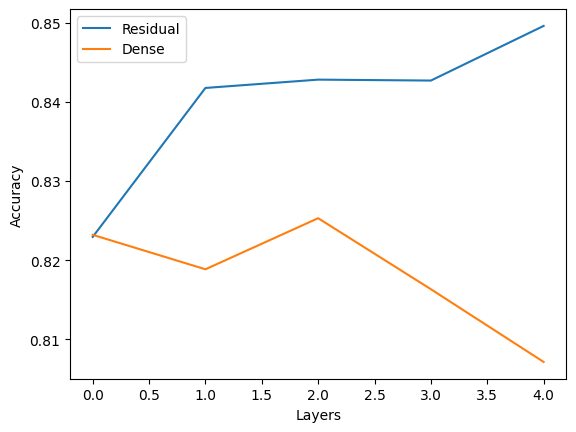

CPU times: user 49 s, sys: 751 ms, total: 49.7 s
Wall time: 45.1 s


In [18]:
%%time
finals = [compare_residual(i,1) for i in range(5)]
plt.plot([x[0] for x in finals], label = "Residual")
plt.plot([x[1] for x in finals], label = "Dense")
plt.xlabel("Layers")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Increasing the number of epochs helps with the gap between models. However, the separation between the two accuracies remains no matter how long the network is trained for. Residual connections ensure that simple solutions can be found at arbitrary depth, while also allowing the model to become more complex if needed.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">To test your understanding of improving the performance of residual layers, run the following cell.</p>
    <br>
</div>

In [ ]:
question_3

----
## Conclusion

In this Lab, you saw how to implement residual layers and how to use them to improve the performance of deep neural networks. You also saw how to compare their performance with dense connections on the Fashion-MNIST dataset.

By plotting the figure over a variety of depths and comparing the accuracy after a single epoch of training, you observed that the network with residual connections performed better than the network with dense connections, even after a single epoch.

Although increasing the number of epochs helps to close the gap, the separation between the two accuracies remains no matter how long the network is trained for.

Residual layers and networks are a valuable addition to deep learning, especially for tasks that involve complex and highly nonlinear patterns, such as image classification.

--- 
## Next lab
In the next lab, you will learn how to build a model using a modern ConvNeXt architecture with PyTorch.